In [1]:
import GPUtil
GPUtil.getAvailable()

[]

In [2]:
import torch
use_cuda = torch.cuda.is_available()
use_cuda

False

In [3]:
device = torch.device("cuda" if use_cuda else "cpu")
print("Device: ",device)

Device:  cpu


In [1]:
import os
import cv2
import random
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from patchify import patchify
from PIL import Image
import segmentation_models as sm
from keras.utils import to_categorical
from tensorflow.python.keras.metrics import MeanIoU

from preparation import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

Segmentation Models: using `keras` framework.


In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
from simple_multi_unet_model import multi_unet_model, jacard_coef

In [4]:
# Specify the dataset directory
root_directory = 'datasets/solar panel dataset'

patch_size = 256

In [5]:
# Load the dataset
image_dataset, mask_dataset = load_solar_panel_dataset(image_dir=root_directory, patch_size=patch_size)

patchifying image: datasets/solar panel dataset/PV01_324958_1203803.png
patchifying mask: datasets/solar panel dataset/PV01_324958_1203803.png
patchifying image: datasets/solar panel dataset/PV01_324972_1203798.png
patchifying mask: datasets/solar panel dataset/PV01_324972_1203798.png
patchifying image: datasets/solar panel dataset/PV01_325120_1204229.png
patchifying mask: datasets/solar panel dataset/PV01_325120_1204229.png
patchifying image: datasets/solar panel dataset/PV01_325122_1203834.png
patchifying mask: datasets/solar panel dataset/PV01_325122_1203834.png
patchifying image: datasets/solar panel dataset/PV01_325123_1204229.png
patchifying mask: datasets/solar panel dataset/PV01_325123_1204229.png
patchifying image: datasets/solar panel dataset/PV01_325125_1204232.png
patchifying mask: datasets/solar panel dataset/PV01_325125_1204232.png
patchifying image: datasets/solar panel dataset/PV01_325125_1204248.png
patchifying mask: datasets/solar panel dataset/PV01_325125_1204248.png

In [6]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

In [7]:
# this code shows our mask images objects aren't classified
# So we must classify them in the preprocessing step
unique_img_hex = unique_img_hex_val_colors(mask_dataset[507])
unique_img_hex

array(['#000000', '#020202', '#030303', '#040404', '#060606', '#080808',
       '#090909', '#0a0a0a', '#0b0b0b', '#0c0c0c', '#0d0d0d', '#0e0e0e',
       '#101010', '#131313', '#151515', '#181818', '#1a1a1a', '#1b1b1b',
       '#1c1c1c', '#1d1d1d', '#1e1e1e', '#202020', '#212121', '#232323',
       '#2a2a2a', '#2c2c2c', '#2f2f2f', '#303030', '#313131', '#323232',
       '#333333', '#353535', '#363636', '#373737', '#383838', '#3c3c3c',
       '#3e3e3e', '#3f3f3f', '#404040', '#424242', '#454545', '#494949',
       '#4b4b4b', '#4c4c4c', '#4d4d4d', '#525252', '#545454', '#5a5a5a',
       '#5c5c5c', '#5d5d5d', '#5e5e5e', '#5f5f5f', '#616161', '#626262',
       '#656565', '#666666', '#6a6a6a', '#6c6c6c', '#6f6f6f', '#707070',
       '#727272', '#737373', '#757575', '#767676', '#777777', '#787878',
       '#797979', '#7a7a7a', '#7c7c7c', '#7d7d7d', '#7e7e7e', '#7f7f7f',
       '#808080', '#818181', '#828282', '#838383', '#858585'], dtype='<U7')

But we have 2 color classes: #d3d3d3 and #000000

In [8]:
mask_dataset = rgb_to_hex_dataset(mask_dataset)

In [9]:
labels = rgb_to_2D_dataset(dataset=mask_dataset)

In [10]:
mask_dataset.shape

(744, 256, 256, 3)

In [11]:
np.unique(mask_dataset)

array([  0, 211], dtype=uint8)

In [12]:
print(len(labels), mask_dataset.shape[0])

744 744


In [13]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [14]:
labels.shape

(744, 256, 256, 1)

In [15]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0. 1.]


In [16]:
np.unique(labels[100]), labels[:,:,:,0].shape

(array([0., 1.], dtype=float32), (744, 256, 256))

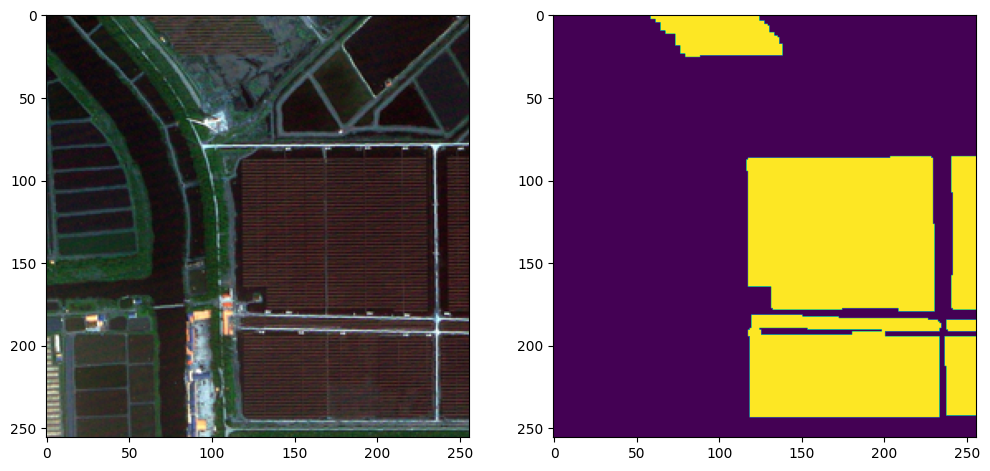

In [17]:
rand_number = random.randint(0, 700)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[rand_number])
plt.subplot(122)
test = labels[rand_number][:,:,0].copy()
plt.imshow(test)
plt.show()

In [18]:
label = np.arange(65536).reshape(256,256)
type(label), label.shape

(numpy.ndarray, (256, 256))

In [19]:
n_classes = len(np.unique(labels))
labels_cat = to_categorical(labels, num_classes=n_classes)
n_classes

2

In [20]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

# Parameters for the model

In [21]:
weights = [0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [22]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [23]:
metrics=['accuracy', jacard_coef]

# Create model

In [24]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [24]:
model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [26]:
model.input_shape, model.output_shape

((None, 256, 256, 3), (None, 256, 256, 2))

# Train the model

In [25]:
# run this if you consider pre-trained model
import keras
import pickle
from keras.models import load_model


with keras.utils.custom_object_scope({
    'dice_loss_plus_1focal_loss': total_loss,
    'jacard_coef': jacard_coef
}):
    model = load_model("models/trained_satellite_standard_unet_30epochs_v4.hdf5")

model.compile(optimizer='adam', loss=total_loss, metrics=metrics)

In [26]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=10,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/10
38/38 [==============================] - 148s 4s/step - loss: 0.8889 - accuracy: 0.9181 - jacard_coef: 0.7581 - val_loss: 0.8606 - val_accuracy: 0.9447 - val_jacard_coef: 0.8464
Epoch 2/10
38/38 [==============================] - 142s 4s/step - loss: 0.8595 - accuracy: 0.9487 - jacard_coef: 0.8571 - val_loss: 0.8537 - val_accuracy: 0.9625 - val_jacard_coef: 0.8983
Epoch 3/10
38/38 [==============================] - 133s 4s/step - loss: 0.8539 - accuracy: 0.9610 - jacard_coef: 0.8937 - val_loss: 0.8515 - val_accuracy: 0.9655 - val_jacard_coef: 0.9084
Epoch 4/10
38/38 [==============================] - 133s 4s/step - loss: 0.8504 - accuracy: 0.9675 - jacard_coef: 0.9110 - val_loss: 0.8497 - val_accuracy: 0.9684 - val_jacard_coef: 0.9173
Epoch 5/10
38/38 [==============================] - 133s 4s/step - loss: 0.8487 - accuracy: 0.9703 - jacard_coef: 0.9188 - val_loss: 0.8493 - val_accuracy: 0.9694 - val_jacard_coef: 0.9226
Epoch 6/10
38/38 [==============================] - 133

In [27]:
model.save('models/trained_satellite_standard_unet_10epochs_v5.hdf5')
#model.save('models/trained_satellite_standard_unet_100epochs_v2_history.hdf5')
np.save('models/trained_satellite_standard_unet_10epochs_v5_history',history1.history)

In [28]:
import keras
import pickle
from keras.models import load_model


with keras.utils.custom_object_scope({
    'dice_loss_plus_1focal_loss': total_loss,
    'jacard_coef': jacard_coef
}):
    model = load_model("models/trained_satellite_standard_unet_20epochs_v3.hdf5")

In [29]:
# loading the history of model
history = np.load('models/trained_satellite_standard_unet_20epochs_v3_history.npy',allow_pickle='TRUE').item()

'''
with open('models/trained_satellite_standard_unet_100epochs_v2_history.npy', "rb") as file_pi:
    history = pickle.load(file_pi)
'''

'\nwith open(\'models/trained_satellite_standard_unet_100epochs_v2_history.npy\', "rb") as file_pi:\n    history = pickle.load(file_pi)\n'

In [30]:
history

{'loss': [0.8601012229919434,
  0.8501080274581909,
  0.845737636089325,
  0.845849335193634,
  0.8444873690605164,
  0.8431485891342163,
  0.8425693511962891,
  0.8427139520645142,
  0.8431030511856079,
  0.844282329082489,
  0.8439313769340515,
  0.8427976369857788,
  0.8414419889450073,
  0.84129798412323,
  0.840518593788147,
  0.8402853012084961,
  0.84038245677948,
  0.8404864072799683,
  0.8403469324111938,
  0.8398083448410034],
 'accuracy': [0.9751297831535339,
  0.9828731417655945,
  0.9874213337898254,
  0.9875777363777161,
  0.9884060621261597,
  0.9896389245986938,
  0.9902439117431641,
  0.9898948669433594,
  0.9894583821296692,
  0.9884618520736694,
  0.9886592030525208,
  0.9900411367416382,
  0.9912091493606567,
  0.9915958642959595,
  0.992230236530304,
  0.9924231767654419,
  0.992384135723114,
  0.9921989440917969,
  0.9923468828201294,
  0.9930561184883118],
 'jacard_coef': [0.9347168803215027,
  0.9577754735946655,
  0.9682267308235168,
  0.9680145978927612,
  0.9

In [31]:
loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)

acc = history['jacard_coef']
val_acc = history['val_jacard_coef']

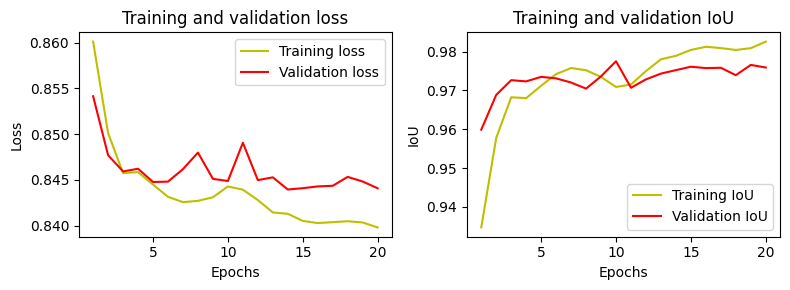

In [32]:
#plot the training and validation accuracy and loss at each epoch

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(epochs, loss, 'y', label='Training loss')
ax1.plot(epochs, val_loss, 'r', label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, 'y', label='Training IoU')
ax2.plot(epochs, val_acc, 'r', label='Validation IoU')
ax2.set_title('Training and validation IoU')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('IoU')
ax2.legend()

plt.tight_layout()
plt.show()

In [33]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)
#y_test_argmax = np.reshape(y_test, (149,256,256))

5/5 [==============================] - 6s 1s/step


In [34]:
np.unique(y_test_argmax[0]), np.unique(y_test), y_test_argmax[0].shape, y_test[0].shape

(array([0, 1], dtype=int64),
 array([0., 1.], dtype=float32),
 (256, 256),
 (256, 256, 2))

In [35]:
# Using built-in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.80327314


In [36]:
X_test[0].shape

(256, 256, 3)

1/1 [==============================] - 0s 62ms/step


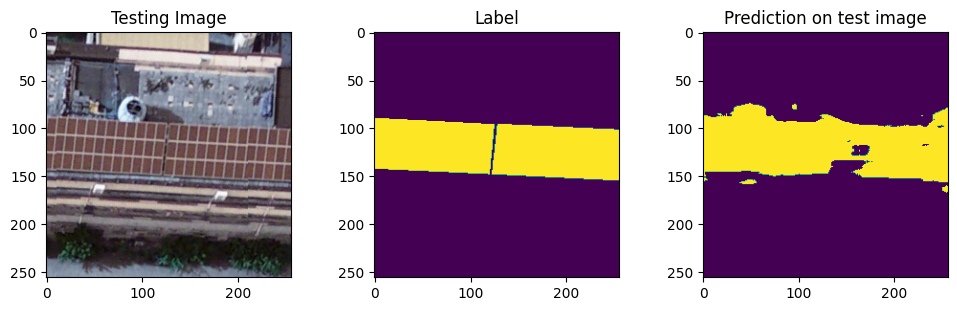

In [43]:
# Predict on a few images

plt = rand_predict_result_dataset(model, X_test, y_test_argmax)
plt.show()